# Sampling from probability distributions 

In [1]:
import numpy as np
from collections import defaultdict
from math import factorial as fac
import matplotlib.pyplot as plt
import math
import copy

### Sampling from Cauchy distribution using Metropolis-Hastings algorithm

Let $p(x) = \frac{1}{\pi} \frac{1}{x^2+1}$ be the Cauchy distribution. We want to use Metropolis-Hastings algorithm to sample from this distribution. Let the proposal sampling distribution be $$Q(x ; x') = \frac{1}{\sqrt{2\pi}} \exp \left(-\frac{1}{2} (x - x')^2 \right).$$ It is assumed that we can sample from this distribution and we want to use this distribution to sample using Metropolis-Hastings algorithm. Since $Q$ is symmetric and in fact $Q(x ; x') = Q(x' ; x)$, we can compute the acceptance probability as $$A(x \to x') = \min \left(1, \frac{p(x') Q(x' ; x)}{p(x) Q(x ; x')}\right) = \min \left(1, \frac{p(x') }{p(x)}\right) = \min \left(1, \frac{1 + x^2}{1+ {x'}^2}\right).$$ Therefore, the algorithm will look like the following. 

In [3]:
def metropolis_hastings_cauchy(N, init_point=0):
    out = [init_point]
    for _ in range(N-1):
        previous_point = out[-1]
        candidate_point = previous_point + np.random.randn()
        p = min(1, (1+previous_point**2)/(1+candidate_point**2))
        if np.random.uniform() < p:
            out.append(candidate_point)
        else:
            out.append(previous_point)
    return out

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


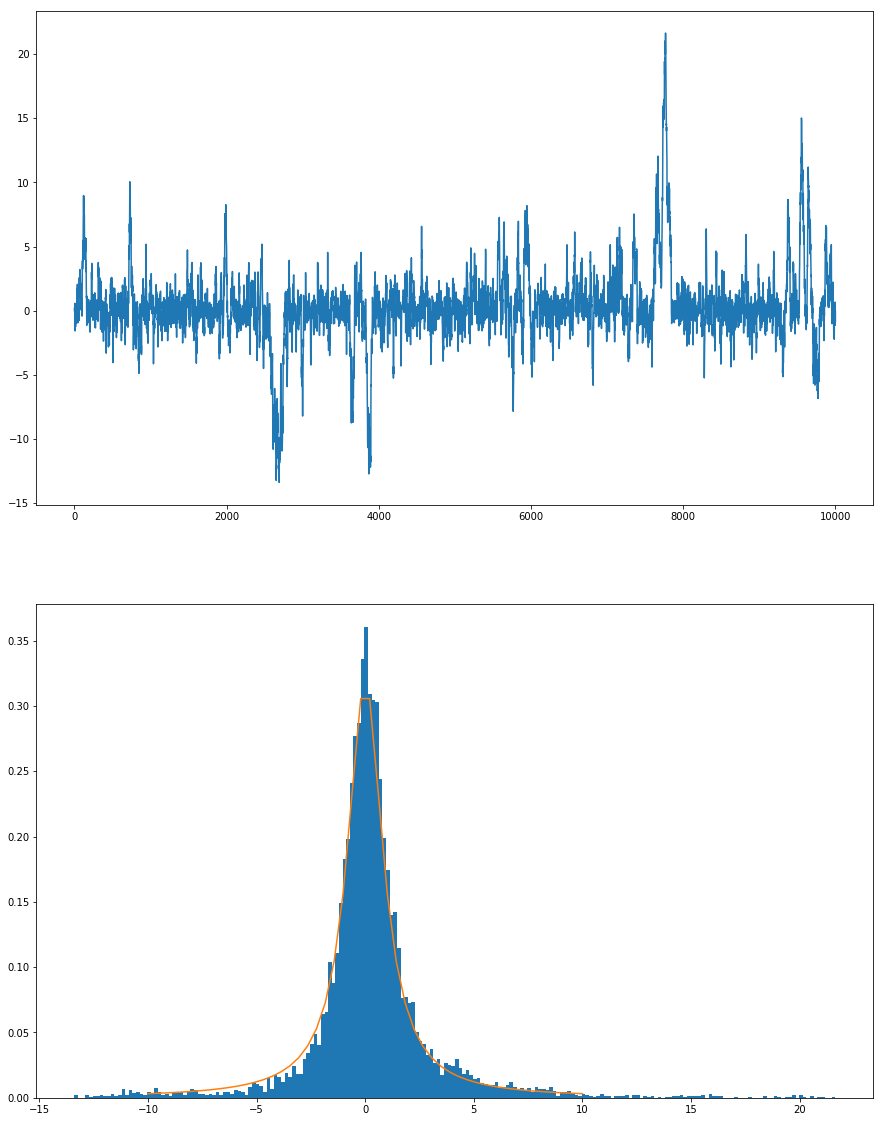

In [4]:
N = 10000
mcmc_samples_cauchy = metropolis_hastings_cauchy(N)
f, (ax1, ax2) = plt.subplots(2,1,figsize=(15,20))
ax1.plot(list(range(N)), mcmc_samples_cauchy)
a = ax2.hist(mcmc_samples_cauchy, bins='auto', normed=1)

x1 = np.linspace(-10, 10)
y1 = 1/(np.pi*(1+x1**2))
b = ax2.plot(x1,y1)

### Sampling from Binomial distribution

Using uniform sampling in Numpy

In [5]:
def sample_binom_using_random(n, p):
    return np.sum(np.random.uniform(0, 1, n) > 1 - p)

Using choice function in Numpy

In [6]:
def sample_binom_using_choice(n, p):
    return np.sum(np.random.choice(np.arange(0, 2), n, p=[1-p, p]))

Tools to verify our sampling methods 

In [7]:
def coeff_binom(n,p,k):
    return (fac(n)/(fac(k)*fac(n-k)))*(p**k)*((1-p)**(n-k))

In [8]:
def simulate_binom(n,p, iters, func):
    a = defaultdict(int)
    for i in range(iters):
        a[func(n, p)] += 1
    return [a[i]/iters for i in range(n)]

In [9]:
def kl_divergence(p1, p2):
    assert len(p1)==len(p2), "Probability distributions should have the same length"
    n = len(p1)
    s = 0 
    for i in range(n):
        if p1[i] < 0 or p2[i] < 0:
            print("Invalid probability distributions!")
            return 
        if p1[i] > 0 and p2[i] == 0:
            return float("inf")
        if p1[i] > 0 and p2[i] > 0:
            s += p1[i]*(math.log(p1[i]) - math.log(p2[i]))
    return s

In [10]:
def compute_kl_distances(iterVec, n, p, func):
    output = []
    for iters in iterVec:
        a = simulate_binom(n, p, iters, func)
        b = [coeff_binom(n,p,k) for k in range(n)]
        output.append(kl_divergence(a, b))
    return output 

Verifying that the KL divergence between the sampled distributions and the actual distribution goes to 0

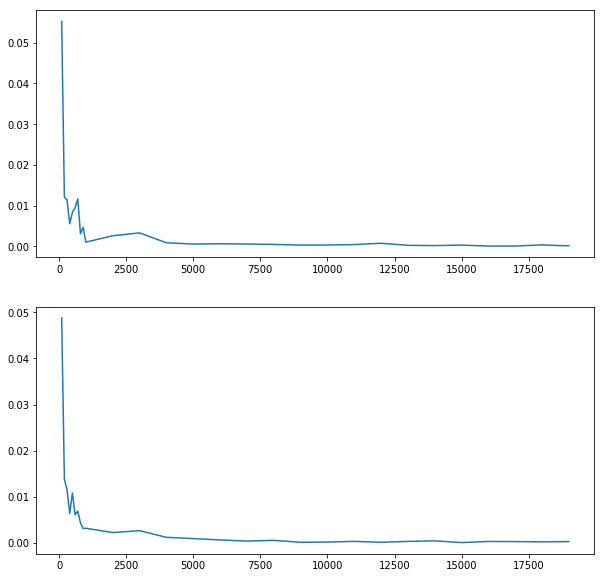

In [11]:
iterVec = list(range(100,1000,100))+list(range(1000, 20000, 1000))
n = 10 
p = 0.2 
f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,10))
kls1 = compute_kl_distances(iterVec, n, p, sample_binom_using_random)
ax1.plot(iterVec, kls1)
kls2 = compute_kl_distances(iterVec, n, p, sample_binom_using_choice)
ax2.plot(iterVec, kls2)

### Sampling Multinomial distribution

###### Using binomial sampling 
We can sample from a multinomial distribution using a binomial distribution. For proof of correctness, please see the following link.
https://stats.stackexchange.com/questions/122907/can-multinomial-distribution-be-simulated-by-a-sequence-of-binomial-draws/419399#419399

In [12]:
def sample_multinom_using_binom(pVec, k):
    n = len(pVec)
    if n==1:
        return int(np.random.uniform(0, 1, 1) > 1 - pVec[0])
    k1 = sample_binom_using_random(k, pVec[0])
    if n==2:
        return (k1, k-k1) 
    else:
        return (k1, *sample_multinom_using_binom([x/(1-pVec[0]) for x in pVec[1:]], k-k1))

###### Using Numpy multinomial
You can simply sample from a multinomial distribution in Numpy using multinomial function as follows

In [13]:
def sample_multinom_numpy_builtin(pVec, k):
    return list(np.random.multinomial(k, pVec, size=1)[0])

Utility tool to test first moment correctness of our sampling methods. This tool samples $n$ times and computes the average number of samples drawn. Since for multinomial distribution we have $\mathbb{E}[x_i] = n p_i$, this way, we can check whether the average sample values equals $np_i$. If not, the sampling method is wrong. 

In [14]:
def compute_average_sampled_value(iters, func, args, kwargs):
    samples = []
    for _ in range(iters):
        samples.append(func(*args, **kwargs))
    return samples, np.mean(samples, axis = 0)

In [15]:
pVec = [0.1, 0.1, 0.4, 0.1, 0.3]
k = 100
iterations = 10000
_, mean_builtin = compute_average_sampled_value(iterations, sample_multinom_numpy_builtin, (pVec, k), {})
print(mean_builtin/k)
_, mean_using_binom = compute_average_sampled_value(iterations, sample_multinom_using_binom, (pVec, k), {})
print(mean_using_binom/k)

[0.100316 0.099724 0.400256 0.100249 0.299455]
[0.100001 0.099871 0.400634 0.099918 0.299576]


### Sampling from Truncated Multinomial distribution

For a much more insteresting problem consider the truncated multinomial distribution in which we can only accept samples $\vec a \le \vec x \le \vec b$. In other words,

$$\vec x \sim \frac{1}{Z} \frac{p_1^{x_1} \dots p_k^{x_k}}{x_1!\dots x_k!}$$

where $Z$ is a normalization constant, $\vec x$ has $n$ positive components, and $\sum x_i = k$ where we only consider values of $\vec{x}$ in the range $\vec a \le \vec x \le \vec b$. How can we sample this truncated multinomial distribution? Please see the following link for a detailed explanation of this problem
https://stats.stackexchange.com/questions/220919/how-to-sample-a-truncated-multinomial-distribution
In this link, three different sampling algorithms are studied. We will solve the problem using these algorithms in the following.

###### 1. Accept-Reject algorithm

In [16]:
def truncated_multinomial_accept_reject(pVec, k, a, b):
    x = list(np.random.multinomial(k, pVec, size=1)[0])
    h = [x[i] >= a[i] and x[i] <= b[i] for i in range(len(x))]
    while sum(h) < len(h):
        x = list(np.random.multinomial(k, pVec, size=1)[0])
        h = [x[i] >= a[i] and x[i] <= b[i] for i in range(len(x))]
    return x

In [17]:
pVec = [0.1, 0.1, 0.4, 0.1, 0.3]
k = 10
iterations = 10000
a = [1, 2, 2, 2, 1]
b = [4, 5, 5, 5, 7]
_, mean_accept_reject = compute_average_sampled_value(iterations, truncated_multinomial_accept_reject,\
                                                      (pVec, k, a, b), {})
print(mean_accept_reject/k)

[0.12289 0.21578 0.26944 0.21539 0.1765 ]


Notice that in this case, it is not easy to check the first moment correctness. However, we cd still test the algorithm for the trivial case. 

In [18]:
a = [0, 0, 0, 0, 0]
b = [k, k, k, k, k]
_, mean_accept_reject = compute_average_sampled_value(iterations, truncated_multinomial_accept_reject,\
                                                      (pVec, k, a, b), {})
print(mean_accept_reject/k)

[0.0987  0.0995  0.40059 0.09819 0.30302]


###### 2. Direct simulation

In [19]:
def truncated_multinomial_direct_sampling_from_urn(pVec, k, a, b):
    n = len(pVec)
    while True:
        pp = pVec 
        x = [0 for _ in range(n)] 
        while True:
            if sum([x[h] < b[h] for h in range(n)])==1:
                indx = [h for h in range(n) if x[h] < b[h]][0]
                x[indx] = k - sum(x)
                break
            i = np.random.choice(n, 1, p=pp)[0]
            x[i] += 1
            if x[i] == b[i]:
                pp = [pp[j]/(1-pp[i]) for j in range(n)]
                pp[i] = 0 
            if sum(x) == k:
                break  
        if sum([x[h] < a[h] for h in range(n)]) == 0:
            break 
    return x

In [20]:
_, mean_direct_simulation = compute_average_sampled_value(iterations, truncated_multinomial_direct_sampling_from_urn,\
                                                      (pVec, k, a, b), {})
print(mean_direct_simulation/k)

[0.09983 0.09883 0.40321 0.09919 0.29894]


###### 3. Metropolis algorithm

Metropolos-Hastings is the most efficient approach. The algorithm is initialized by using direct simulation 
(but can be initialized differently) to draw first sample $𝑋_1$. In following steps iteratively: proposal value $𝑦=𝑞(𝑋_{𝑖−1})$ is accepted as $𝑋_𝑖$ with probability $𝑓(𝑦)/𝑓(𝑋_{𝑖−1})$, otherwise $𝑋_{𝑖−1}$ value is taken in it's place, where $𝑓(𝑥)∝∏_{𝑖} 𝑝_i^{𝑥_𝑖}/𝑥_𝑖!$. As a proposal, function $𝑞$ that takes $𝑋_{𝑖−1}$ value and randomly flips from 0 to step number of cases and moves it to another category is used.

In [21]:
def compute_log_function(x, pVec, a, b):
    x_less_a = sum([x[i] < a[i] for i in range(len(pVec))])
    x_more_a = sum([x[i] > b[i] for i in range(len(pVec))])
    if x_less_a or x_more_a or sum(x) != k:
        return float("-inf")
    return np.sum(np.log(pVec)*x - np.array([math.lgamma(h+1) for h in x]))

In [22]:
def sampling_distribution(original, pVec, a, b, step):
    x = copy.deepcopy(original) 
    idx = np.random.choice(len(x), 2, replace=False)
    u = np.random.choice(step, 1)[0]
    x[idx[0]] -= u
    x[idx[1]] += u
    x_less_a = sum([x[i] < a[i] for i in range(len(pVec))])
    x_more_a = sum([x[i] > b[i] for i in range(len(pVec))])
    while x_less_a or x_more_a or sum(x) != k:
        x = copy.deepcopy(original)  
        idx = np.random.choice(len(x), 2, replace=False)
        u = np.random.choice(step, 1)[0]
        x[idx[0]] -= u
        x[idx[1]] += u
        x_less_a = sum([x[i] < a[i] for i in range(len(pVec))])
        x_more_a = sum([x[i] > b[i] for i in range(len(pVec))])
    return x 

In [23]:
def sample_truncated_multinomial_metropolis_hasting(pVec, k, a, b, iters, step=1):
    x = truncated_multinomial_accept_reject(pVec, k, a, b)
    step = max(2, step)
    ar = 0 
    for i in range(iters):
        proposal = sampling_distribution(x, pVec, a, b, step)
        if compute_log_function(proposal, pVec, a, b) == float("-inf"):
            continue             
        prob = np.exp(np.array(compute_log_function(proposal, pVec, a, b)) -\
                      np.array(compute_log_function(x, pVec, a, b)))
        if np.random.uniform() < prob:
            x = proposal 
            ar += 1 
    acceptance_rate = ar/iters
    #print('acceptance rate :', acceptance_rate)
    step -= 1 
    return x

In [24]:
iterations = 100
metropolis_iters = 1000
_, mean_metropolis = compute_average_sampled_value(iterations, sample_truncated_multinomial_metropolis_hasting,\
                                                      (pVec, k, a, b, metropolis_iters), {'step': 1})
print(mean_metropolis/k)

[0.091 0.106 0.395 0.09  0.318]
